### Model Design Challenge (Extra credit: Maximum 20 points) 🚀

In [6]:
import os
import random
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


def get_price(tick, start='2022-10-01', end=None):
    return yf.Ticker(tick).history(start=start, end=end)['Close']


def get_prices(tickers, start='2022-10-01', end=None):
    df = pd.DataFrame()
    for s in tickers:
        df[s] = get_price(s, start, end)
    return df


def set_all_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)


# Data preparation
feature_stocks = ['tsla', 'meta', 'goog', 'amzn', 'nflx', 'gbtc', 'gdx', 'intc', 'dal', 'c']
predict_stock = 'msft'

splits = {
    'train': ('2023-01-01', '2024-06-30'),
    'val': ('2024-07-01', '2024-10-31'),
    'test': ('2024-11-01', '2024-12-31'),
}


def build_split(start, end):
    X_df = get_prices(feature_stocks, start=start, end=end)
    y_df = get_prices([predict_stock], start=start, end=end)
    target_col = y_df.columns[0]
    df = pd.concat([X_df, y_df], axis=1).dropna()
    X = df[feature_stocks].to_numpy(dtype=np.float32)
    y = df[target_col].to_numpy(dtype=np.float32).reshape(-1, 1)
    return X, y


X_train_nn, y_train_nn = build_split(*splits['train'])
X_val_nn, y_val_nn = build_split(*splits['val'])
X_test_nn, y_test_nn = build_split(*splits['test'])

# Standardize with train statistics only
x_mean = X_train_nn.mean(axis=0, keepdims=True)
x_std = X_train_nn.std(axis=0, keepdims=True) + 1e-8

y_mean = y_train_nn.mean(axis=0, keepdims=True)
y_std = y_train_nn.std(axis=0, keepdims=True) + 1e-8

X_train_nn_std = (X_train_nn - x_mean) / x_std
X_val_nn_std = (X_val_nn - x_mean) / x_std
X_test_nn_std = (X_test_nn - x_mean) / x_std

y_train_nn_std = (y_train_nn - y_mean) / y_std
y_val_nn_std = (y_val_nn - y_mean) / y_std
y_test_nn_std = (y_test_nn - y_mean) / y_std

set_all_seeds(42)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

X_train_t = torch.tensor(X_train_nn_std, dtype=torch.float32)
y_train_t = torch.tensor(y_train_nn_std, dtype=torch.float32)
X_val_t = torch.tensor(X_val_nn_std, dtype=torch.float32)
y_val_t = torch.tensor(y_val_nn_std, dtype=torch.float32)
X_test_t = torch.tensor(X_test_nn_std, dtype=torch.float32)
y_test_t = torch.tensor(y_test_nn_std, dtype=torch.float32)


def build_train_loader(seed=42, batch_size=32):
    g = torch.Generator()
    g.manual_seed(seed)
    return DataLoader(
        TensorDataset(X_train_t, y_train_t),
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        generator=g,
    )


class FCRegressor(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 20), nn.ReLU(),
            nn.Linear(20, 20), nn.ReLU(),
            nn.Linear(20, 20), nn.ReLU(),
            nn.Linear(20, 20), nn.ReLU(),
            nn.Linear(20, 20), nn.ReLU(),
            nn.Linear(20, 1),
        )

    def forward(self, x):
        return self.net(x)


print('Prepared tensors:', X_train_t.shape, X_val_t.shape, X_test_t.shape)



Prepared tensors: torch.Size([374, 10]) torch.Size([86, 10]) torch.Size([40, 10])


Baseline params:  1,921
Challenge params: 1,594


100%|██████████| 250/250 [00:10<00:00, 23.78it/s]

Baseline MSE: 0.169835
Challenge MSE: 0.039874


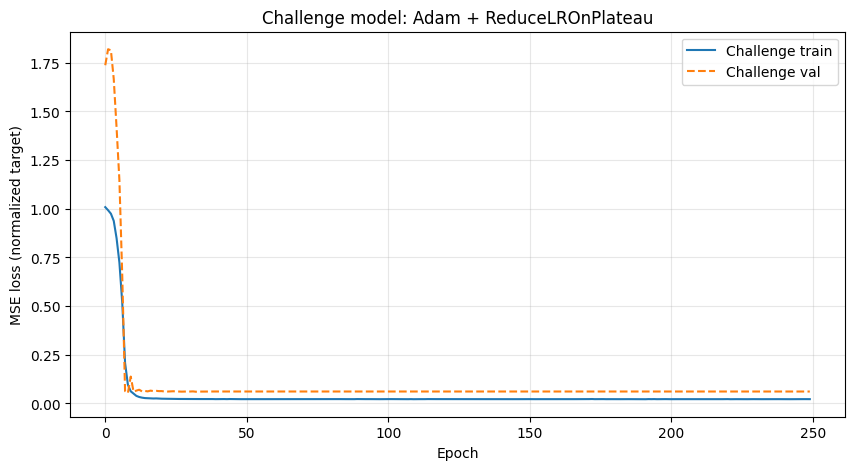

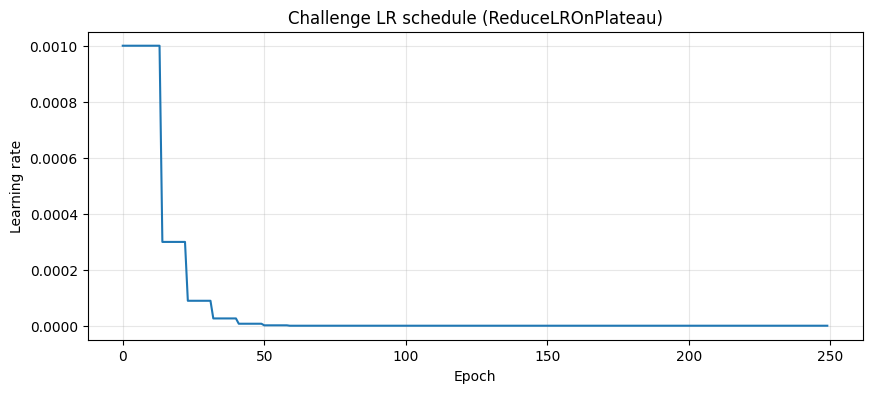

In [29]:
# Challenge: use Adam + ReduceLROnPlateau with <= previous best 

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

class ChallengeRegressor(nn.Module):
    def __init__(self, in_dim, hidden_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2), #nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        return self.net(x)


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Baseline (previous model) parameter budget
baseline_model = FCRegressor(in_dim=X_train_t.shape[1]).to(device)
baseline_params = count_params(baseline_model)

# Challenge model (must be <= baseline)
challenge_model = ChallengeRegressor(in_dim=X_train_t.shape[1], hidden_dim=18).to(device)
challenge_params = count_params(challenge_model)

print(f"Baseline params:  {baseline_params:,}")
print(f"Challenge params: {challenge_params:,}")

assert challenge_params <= baseline_params, "Challenge model exceeds parameter budget"

# Sync hyperparameters with the tuned setup above
challenge_seed = 42
set_all_seeds(challenge_seed)
train_loader = build_train_loader(seed=challenge_seed, batch_size=32)
challenge_lr = 1e-3
challenge_epochs = 250
optimizer = optim.Adam(challenge_model.parameters(), lr=challenge_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.3,
    patience=5,
    threshold=1e-3,
    cooldown=3,
    min_lr=1e-6,
)
criterion = nn.MSELoss()

challenge_history = {'train_loss': [], 'val_loss': [], 'lr': []}

for _ in tqdm(range(challenge_epochs)):
    challenge_model.train()
    batch_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = challenge_model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    challenge_model.eval()
    with torch.no_grad():
        val_pred = challenge_model(X_val_t.to(device))
        val_loss = criterion(val_pred, y_val_t.to(device)).item()

    scheduler.step(val_loss)

    challenge_history['train_loss'].append(float(sum(batch_losses) / len(batch_losses)))
    challenge_history['val_loss'].append(float(val_loss))
    challenge_history['lr'].append(float(optimizer.param_groups[0]['lr']))

# Testing (normalized target scale)
challenge_model.eval()
with torch.no_grad():
    test_pred = challenge_model(X_test_t.to(device))
    test_mse = criterion(test_pred, y_test_t.to(device)).item()

best_epoch = int(min(range(len(challenge_history['val_loss'])), key=lambda i: challenge_history['val_loss'][i]))
best_val = challenge_history['val_loss'][best_epoch]

# print(f"Best val MSE: {best_val:.6f} (epoch {best_epoch + 1})")
print(f"Baseline MSE: 0.169835")
print(f"Challenge MSE: {test_mse:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(challenge_history['train_loss'], label='Challenge train')
plt.plot(challenge_history['val_loss'], '--', label='Challenge val')
plt.xlabel('Epoch')
plt.ylabel('MSE loss (normalized target)')
plt.title('Challenge model: Adam + ReduceLROnPlateau')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(challenge_history['lr'])
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Challenge LR schedule (ReduceLROnPlateau)')
plt.grid(alpha=0.3)
plt.show()



### Upload model to Hugging Face Model Hub
Run the next cell after training. It saves artifacts locally and uploads them to your HF model repo.

In [33]:
import json
from pathlib import Path

# 1) Save model artifacts locally
artifact_dir = Path('challenge_artifacts')
artifact_dir.mkdir(parents=True, exist_ok=True)

model_path = artifact_dir / 'pytorch_model.pt'
config_path = artifact_dir / 'config.json'
metrics_path = artifact_dir / 'metrics.json'
readme_path = artifact_dir / 'README.md'

torch.save(
    {
        'model_state_dict': challenge_model.state_dict(),
        'in_dim': int(X_train_t.shape[1]),
        'hidden_dim': 16,
        'feature_stocks': feature_stocks,
        'predict_stock': predict_stock,
        'split_dates': splits,
        'normalization': {
            'x_mean': x_mean.tolist(),
            'x_std': x_std.tolist(),
            'y_mean': y_mean.tolist(),
            'y_std': y_std.tolist(),
        },
    },
    model_path,
)

with open(config_path, 'w') as f:
    json.dump(
        {
            'model_class': 'ChallengeRegressor',
            'in_dim': int(X_train_t.shape[1]),
            'hidden_dim': 16,
            'optimizer': 'Adam',
            'scheduler': 'ReduceLROnPlateau',
            'scheduler_params': {
                'mode': 'min',
                'factor': 0.3,
                'patience': 5,
                'threshold': 1e-3,
                'cooldown': 3,
                'min_lr': 1e-6,
            },
        },
        f,
        indent=2,
    )

with open(metrics_path, 'w') as f:
    json.dump(
        {
            'best_val_mse_normalized': float(best_val),
            'best_val_epoch': int(best_epoch + 1),
            'test_mse_normalized': float(test_mse),
        },
        f,
        indent=2,
    )

readme_path.write_text(
    '# MSFT Challenge Model\n\n'
    'PyTorch model trained in `hw1.challenge.ipynb`.\n\n'
    '## Files\n'
    '- `pytorch_model.pt`: model state dict + metadata\n'
    '- `config.json`: architecture/training config\n'
    '- `metrics.json`: validation/test MSE (normalized target scale)\n',
    encoding='utf-8',
)

print(f'Saved artifacts to: {artifact_dir.resolve()}')

# 2) Upload to Hugging Face Model Hub

from huggingface_hub import HfApi, get_token


def upload_to_hf(repo_id, private=False, token=None):
    token = (
        token
        or os.getenv('HF_TOKEN')
        or os.getenv('HUGGINGFACE_HUB_TOKEN')
        or get_token()  # token from `hf auth login`
    )
    if not token:
        raise ValueError('Missing HF token. Run `hf auth login`, set HF_TOKEN, or pass token=...')

    api = HfApi(token=token)
    api.create_repo(repo_id=repo_id, repo_type='model', private=private, exist_ok=True)
    api.upload_folder(
        folder_path=str(artifact_dir),
        repo_id=repo_id,
        repo_type='model',
        commit_message='Upload challenge model artifacts',
    )

    print(f'Uploaded to: https://huggingface.co/{repo_id}')

upload_to_hf(repo_id='iaaronlau/ANN2026', private=False)



Saved artifacts to: /Users/shouyueliu/projects/ann_2026/challenge_artifacts


/Users/shouyueliu/miniforge3/envs/ann_2026/lib/python3.11/site-packages/huggingface_hub/hf_api.py:9786: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploaded to: https://huggingface.co/iaaronlau/ANN2026
